In [1]:
import spectrum
from matplotlib import pyplot as plt
from astropy.stats import biweight_midvariance, biweight_location
import numpy as np
from scipy.interpolate import UnivariateSpline
import os
import glob

%matplotlib inline

In [2]:
ff = ["../data/ncgama09E_013.fits.gz", "../data/ncgama09E_014.fits.gz"]
ff = glob.glob("../data/ncgama09E_???.fits.gz")[:10]
#rr = [1/np.sqrt(np.pi), 2., 5., 10. ]
r = 5.

# determine wavelength grid once
f = ff[0]
nc = spectrum.readSpectrum(f)
ww = nc.grid()

sss = np.zeros([len(ff),  len(ww)], dtype=float)

In [6]:
for i, f in enumerate(ff):
    print("operating on ", f)
    nc = spectrum.readSpectrum(f)
    
    xx,yy = np.arange(nc.data.shape[2]), np.arange(nc.data.shape[1])
    XX,YY = np.meshgrid(xx,yy)
    xc,yc = np.mean(xx), np.mean(yy)

    ss = {}


    rmax = r/.5 # arcsec to pixel
    ddsq = (((XX-xc)**2.) + ((YY-yc)**2))

    mask = ddsq <= rmax**2.

    ss[r] = []
    for k in range(len(ww)):
        sss[i,k] = np.sqrt(biweight_midvariance( nc.data[k][mask]) )


operating on  ../data/ncgama09E_013.fits.gz
operating on  ../data/ncgama09E_014.fits.gz
operating on  ../data/ncgama09E_015.fits.gz
operating on  ../data/ncgama09E_016.fits.gz
operating on  ../data/ncgama09E_021.fits.gz
operating on  ../data/ncgama09E_022.fits.gz
operating on  ../data/ncgama09E_023.fits.gz
operating on  ../data/ncgama09E_024.fits.gz
operating on  ../data/ncgama09E_025.fits.gz
operating on  ../data/ncgama09E_026.fits.gz


Text(0, 0.5, 'noiselevel  per 10 arcsec \naperture [$10^{-17} erg s^{-1} A^{-1} cm^{-2}$]')

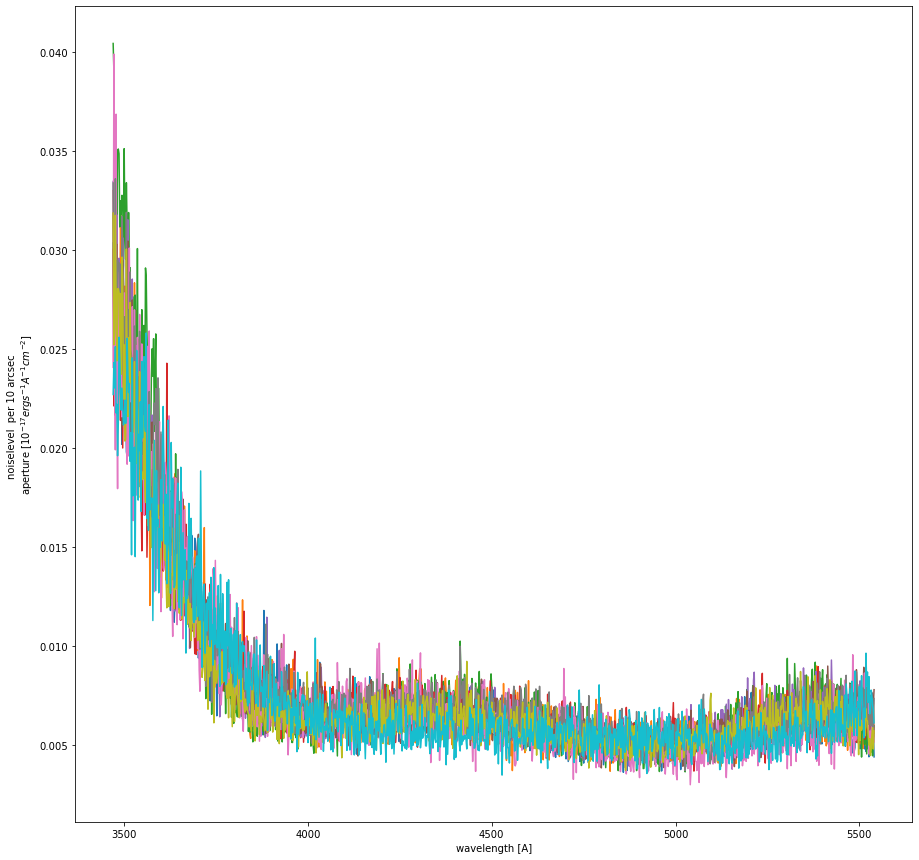

In [7]:

f = plt.figure(figsize=[15,15])

for i, f in enumerate(ff):
    
    yy = sss[i]
    h,t = os.path.split(f)
    plt.plot(ww, yy, label="{}".format(t))

    #ii = ww > 0.
    #spl = UnivariateSpline(ww[ii], ss[r][ii], k=3, s=smoothing)
    #kappa = 3.5
    #sigma = np.nanstd(ss[r]-spl(ww))

    #jj = (np.abs(ss[r]-spl(ww)) < kappa*sigma) 
    #spl = UnivariateSpline(ww[ii*jj],  ss[r][ii*jj], k=3, s=smoothing)

    #plt.plot(ww, spl(ww), label="{:.1f} arcsec".format(r*2))

#plt.legend()

plt.xlabel('wavelength [A]')
plt.ylabel('noiselevel  per 10 arcsec \naperture [$10^{-17} erg s^{-1} A^{-1} cm^{-2}$]')

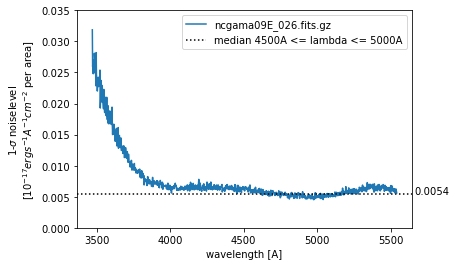

In [14]:
smoothing = 0.003

dLambda = 5.5
dLambda_native = 2.
A_native = 0.5**2.
#A = 5.**2*np.pi
A = 0.5**2.

    

mm = np.median( sss, axis=0 )
h,t = os.path.split(f)
#plt.plot(ww, yy/np.sqrt(dLambda/dLambda_native)/np.sqrt(A/A_native))


plt.plot(ww, mm, label="{}".format(t))

#ii = ww > 0.
#spl = UnivariateSpline(ww[ii], ss[r][ii], k=3, s=smoothing)
#kappa = 3.5
#sigma = np.nanstd(ss[r]-spl(ww))

#jj = (np.abs(ss[r]-spl(ww)) < kappa*sigma) 
#spl = UnivariateSpline(ww[ii*jj],  ss[r][ii*jj], k=3, s=smoothing)

#plt.plot(ww, spl(ww), label="{:.1f} arcsec".format(r*2))

#plt.yscale('log')
plt.legend()
plt.xlabel('wavelength [A]')
plt.ylabel('1-$\sigma$ noiselevel \n[$10^{-17} erg s^{-1} A^{-1} cm^{-2}$ per area]')
plt.ylim([0.,0.035])

ii = (ww >= 4500.) * (ww <= 5000.)
plt.axhline(np.nanmedian(mm[ii]), c='k', ls=':', label="median 4500A <= lambda <= 5000A")
plt.text(5660,np.nanmedian(mm[ii]), "{:.4f}".format(np.nanmedian(mm[ii])))
plt.legend()

In [220]:
def nextract(s, mask, MAX_SAMPLES = 30, DEBUG=False):
    """
    Shifts the aperture corresponding to a detection around in the noise cube to
    sample the noise N times. The mask is shifted such as to not overlap
    wiht he previous location of the mask

    Original, actual mask
    xxxxxxxxxx
    xxx..xxxxx
    xx...xxxxx
    xxx..xxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 1
    x..xxxxxxx
    ...xxxxxxx
    x..xxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 2
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    x..xxxxxxx
    ...xxxxxxx
    x..xxxxxxx

    Sample 3
    xxxx..xxxx
    xxx...xxxx
    xxxx..xxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 4
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxx..xxxx
    xxx...xxxx
    xxxx..xxxx

    Sample 5
    xxxxxxx..x
    xxxxxx...x
    xxxxxxx..x
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 6
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxx..x
    xxxxxx...x
    xxxxxxx..x
    """


    # determine masked, region size
    xx = np.arange(mask.shape[1])
    yy = np.arange(mask.shape[0])

    X,Y = np.meshgrid(xx,yy)
    minx,maxx = X[mask].min(), X[mask].max()
    miny,maxy = Y[mask].min(), Y[mask].max()
    minshift = 10
    sx = maxx - minx + 2
    sy = maxy - miny + 2
    nx,ny = mask.shape[1]//(sx+minshift), mask.shape[0]//(sy+minshift)

    #f = plt.figure(figsize = [7,7])
    #plt.imshow(mask)

    all_sout = []
    count = 1
    print("Sampling noise in {} separate regions".format( min(nx * ny, MAX_SAMPLES)  ) )
    for i in range(nx):
        for j in range(ny):
            if count > MAX_SAMPLES:
                break
            print("Sampling noise column {} and row {}".format(i, j))
            _mask = mask < 0 # empty mask
            #print(sy*(j), sy*(j+1),sx*(i), sx*(i+1), miny, miny+sy, minx, minx+sx )

            m = mask[miny:miny+sy, minx:minx+sx]
            _mask[(sy+minshift)*(j):(sy+minshift)*(j)+m.shape[0],(sx+minshift)*(i):(sx+minshift)*(i)+m.shape[1]] = m
            
            if DEBUG:
                f = plt.figure(figsize = [7,7])
                plt.imshow(_mask)

            sout = np.zeros( s.data.shape[0]  )
            for k in range(s.data.shape[0]):
                #sout[k] = biweight_location( s.data[k][_mask] )
                sout[k] = np.mean( s.data[k][_mask] )
            all_sout.append(sout)
            count += 1

    ww = s.grid()
    return ww, np.array(all_sout), mask


r = 5.
# mask in some aperture
xx,yy = np.arange(nc.data.shape[2]), np.arange(nc.data.shape[1])
XX,YY = np.meshgrid(xx,yy)
xc,yc = np.mean(xx), np.mean(yy)
rmax = r/.5 # arcsec to pixel
ddsq = (((XX-xc)**2.) + ((YY-yc)**2))
mask = ddsq <= rmax**2.


ww, nsout, mask = nextract(nc, mask, DEBUG=False, MAX_SAMPLES=12)

mm_sampled[np.sum(mask)] = np.std(nsout,axis=0)

Sampling noise in 12 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 2 and row 0
Sampling noise column 2 and row 1
Sampling noise column 2 and row 2
Sampling noise column 2 and row 3


In [222]:
mm_sampled = {}

In [223]:
# single pixel
mask = np.zeros_like(mask, dtype=bool)
mask[int(yc), int(xc)] = True

# two single pixel
mask = np.zeros_like(mask, dtype=bool)
mask[int(yc), int(xc)] = True
mask[int(yc), int(xc)-1] = True
mask[int(yc)-1, int(xc)-1] = True
mask[int(yc)-1, int(xc)] = True

In [224]:
f = ff[0]
nc = spectrum.readSpectrum(f)
ww = nc.grid()

In [225]:
from collections import OrderedDict

In [230]:
mm_sampled = OrderedDict()

for r in [2.5, 5.,7.5, 10.,]:
    # mask in some aperture
    xx,yy = np.arange(nc.data.shape[2]), np.arange(nc.data.shape[1])
    XX,YY = np.meshgrid(xx,yy)
    xc,yc = np.mean(xx), np.mean(yy)
    rmax = r/.5 # arcsec to pixel
    ddsq = (((XX-xc)**2.) + ((YY-yc)**2))
    mask = ddsq <= rmax**2.


    ww, nsout, mask = nextract(nc, mask)

    mm_sampled[np.sum(mask)] = np.std(nsout,axis=0)

Sampling noise in 30 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 2 and row 0
Sampling noise column 2 and row 1
Sampling noise column 2 and row 2
Sampling noise column 2 and row 3
Sampling noise column 2 and row 4
Sampling noise column 2 and row 5
Sampling noise column 3 and row 0
Sampling noise column 3 and row 1
Sampling noise column 3 and row 2
Sampling noise column 3 and row 3
Sampling noise column 3 and row 4
Sampling noise column 3 and row 5
Sampling noise column 4 and row 0
Sampling noise column 4 and row 1
Sampling noise column 4 and row 2
Sampling noise column 4 and row 3
Sampling n

(1e-20, 1e-18)

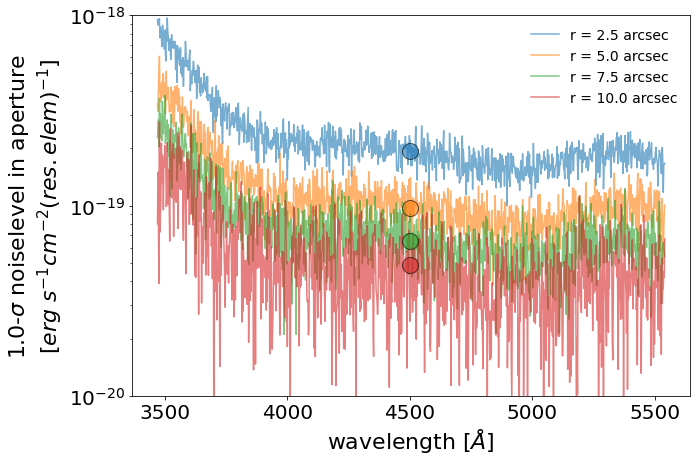

In [425]:
scale = 1e-17 * 4 * 2.01 # x4 to go to SB per arcsec x 2.01 to go to noise per resolution element
#factor = 1.
sigma = 1.

params = {'legend.fontsize': '14',
          'figure.figsize': (15, 5),
         'axes.labelsize': '22',
         'axes.titlesize':'Large',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20'}
plt.rcParams.update(params)

f = plt.figure(figsize=[10,7])



colors = {}
for i, k in enumerate( mm_sampled ):
    # from sampling the cube in apertures
    l = plt.plot(ww, sigma * mm_sampled[k]*scale, label="r = {:.1f} arcsec".format( np.sqrt(k*0.5**2./np.pi) ), alpha=.6)
    colors[k] = l[0].get_color()
    # from scaling the average noise
    #plt.plot(ww, mm/np.sqrt(k), label="{} px".format(k))

for i, k in enumerate( mm_sampled ):
    if i == 0:
        ii = (ww > 4450.) * (ww <= 4550.)
        wwfid = np.mean(ww[ii])
        noisefid = np.mean(mm_sampled[k][ii])
        kfid = k
        plt.plot(wwfid,sigma * noisefid*scale , color=colors[k], marker='o', markeredgecolor='k',markersize=16, alpha=.6)
    else:
        plt.plot(wwfid, sigma * noisefid*(np.sqrt(kfid/k))*scale , color=colors[k], marker='o', markeredgecolor='k',markersize=16, alpha=.6)


l = plt.legend()
l.draw_frame(False)
plt.xlabel("wavelength [$\AA$]")
plt.ylabel(str(sigma) + "-$\sigma$ noiselevel in aperture \n[$ erg\ s^{-1} cm^{-2} (res. elem)^{-1}$]")
plt.yscale('log')
plt.ylim([1e-20,1e-18])

In [280]:
from  scipy.ndimage import gaussian_filter1d

(1e-20, 1e-18)

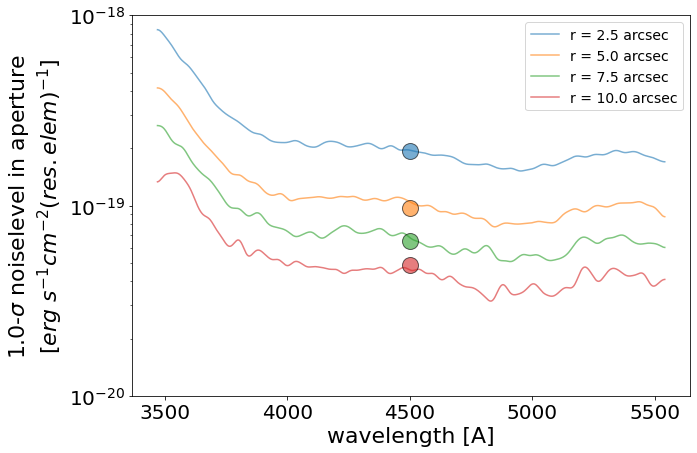

In [427]:
smoothing = 10.

f = plt.figure(figsize=[10,7])


colors = {}
for i, k in enumerate( mm_sampled ):

    l = plt.plot(ww, sigma * gaussian_filter1d(mm_sampled[k], smoothing)*scale , label="r = {:.1f} arcsec".format( np.sqrt(k*0.5**2./np.pi) ), alpha=.6)
    
    colors[k] = l[0].get_color()

for i, k in enumerate( mm_sampled ):
    if i == 0:
        ii = (ww > 4450.) * (ww <= 4550.)
        wwfid = np.mean(ww[ii])
        noisefid = np.mean(mm_sampled[k][ii])
        kfid = k
        plt.plot(wwfid,sigma * noisefid*scale , color=colors[k], marker='o', markeredgecolor='k',markersize=16, alpha=.6)
    else:
        plt.plot(wwfid,sigma * noisefid*(np.sqrt(kfid/k))*scale , color=colors[k], marker='o', markeredgecolor='k',markersize=16, alpha=.6)


plt.legend()
plt.xlabel("wavelength [A]")
plt.ylabel(str(sigma) + "-$\sigma$ noiselevel in aperture \n[$ erg\ s^{-1} cm^{-2} (res. elem)^{-1}$]")
plt.yscale('log')
plt.ylim([1e-20,1e-18])

In [ ]:
scale = 1e-17
smoothing = 0.00010

colors = {}
for i, k in enumerate( mm_sampled ):
    # from sampling the cube in apertures
    #l = plt.plot(ww, mm_sampled[k]*scale, label="{:.1f} arcsec".format( np.sqrt(k*0.5**2./np.pi) ), alpha=.6)
    #colors[k] = l[0].get_color()
    
    
    spl = UnivariateSpline(ww, mm_sampled[k], k=3, s=smoothing)
    l = plt.plot(ww, spl(ww)*scale, label="{:.1f} arcsec".format( np.sqrt(k*0.5**2./np.pi) ), alpha=.6)
    # from scaling the average noise
    #plt.plot(ww, mm/np.sqrt(k), label="{} px".format(k))
    
    colors[k] = l[0].get_color()

for i, k in enumerate( mm_sampled ):
    if i == 0:
        ii = (ww > 4450.) * (ww <= 4550.)
        wwfid = np.mean(ww[ii])
        noisefid = np.mean(mm_sampled[k][ii])
        kfid = k
        plt.plot(wwfid,noisefid*scale, color=colors[k], marker='o', markeredgecolor='k')
    else:
        plt.plot(wwfid,noisefid*(np.sqrt(kfid/k))*scale, color=colors[k], marker='o', markeredgecolor='k')


plt.legend()
plt.xlabel("wavelength [A]")
plt.ylabel("1-$\sigma$ noiselevel in aperture \n[$ erg\ s^{-1} A^{-1} cm^{-2}$]")
plt.yscale('log')

In [ ]:
smoothing = 0.003

dLambda = 5.5
dLambda_native = 2.
A_native = 0.5**2.
#A = 5.**2*np.pi
A = 0.5**2.

    
for j, r in enumerate(rr[:]):
    yy = np.median( sss[:, j], axis=0 )
    h,t = os.path.split(f)
    plt.plot(ww, yy/np.sqrt(dLambda/dLambda_native)/np.sqrt(A/A_native) * 1e-17)
    
    
    plt.plot(ww, yy* 1e-17, label="{}".format(t))

    #ii = ww > 0.
    #spl = UnivariateSpline(ww[ii], ss[r][ii], k=3, s=smoothing)
    #kappa = 3.5
    #sigma = np.nanstd(ss[r]-spl(ww))

    #jj = (np.abs(ss[r]-spl(ww)) < kappa*sigma) 
    #spl = UnivariateSpline(ww[ii*jj],  ss[r][ii*jj], k=3, s=smoothing)

    #plt.plot(ww, spl(ww), label="{:.1f} arcsec".format(r*2))

In [181]:
l[0].get_color()

'#9467bd'

In [152]:
nc.data =np.random.normal(size=nc.data.shape)

In [142]:
N = 1
nsample = 100

samples = []
for i in range(nsample):
    samples.append( np.mean( np.random.normal(size=N) ) )
    
np.std(samples)

1.0859904591229352

In [144]:
N = 4

samples = []
for i in range(nsample):
    samples.append( np.mean( np.random.normal(size=N) ) )
    
np.std(samples)

0.5037581096214246

In [143]:
N = 16

samples = []
for i in range(nsample):
    samples.append( np.mean( np.random.normal(size=N) ) )
    
np.std(samples)

0.25701859022109147

In [128]:
np.std(nsout,axis=0)

array([0.0195569 , 0.02420114, 0.02197772, ..., 0.00460793, 0.00411861,
       0.00480745])

In [105]:
nsout

array([], dtype=float64)

Text(0, 0.5, '1-$\\sigma$ noiselevel \n[$10^{-17} erg s^{-1} A^{-1} cm^{-2}$ per area]')

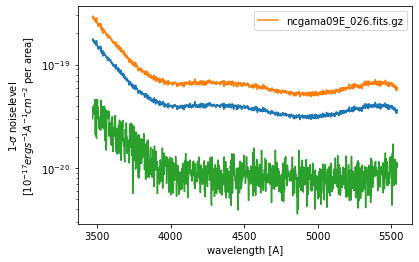

In [101]:
smoothing = 0.003

dLambda = 5.5
dLambda_native = 2.
A_native = 0.5**2.
#A = 5.**2*np.pi
A = 0.5**2.

    
for j, r in enumerate(rr[:]):
    yy = np.median( sss[:, j], axis=0 )
    h,t = os.path.split(f)
    plt.plot(ww, yy/np.sqrt(dLambda/dLambda_native)/np.sqrt(A/A_native) * 1e-17)
    
    
    plt.plot(ww, yy* 1e-17, label="{}".format(t))

    #ii = ww > 0.
    #spl = UnivariateSpline(ww[ii], ss[r][ii], k=3, s=smoothing)
    #kappa = 3.5
    #sigma = np.nanstd(ss[r]-spl(ww))

    #jj = (np.abs(ss[r]-spl(ww)) < kappa*sigma) 
    #spl = UnivariateSpline(ww[ii*jj],  ss[r][ii*jj], k=3, s=smoothing)

    #plt.plot(ww, spl(ww), label="{:.1f} arcsec".format(r*2))

plt.plot(ww, mm*1e-17)

plt.yscale('log')
plt.legend()
plt.xlabel('wavelength [A]')
plt.ylabel('1-$\sigma$ noiselevel \n[$10^{-17} erg s^{-1} A^{-1} cm^{-2}$ per area]')

Text(0, 0.5, 'noislevel [$10^{-17} erg s^{-1} A^{-1} cm^{-2}$ per 10 arcsec aperture]')

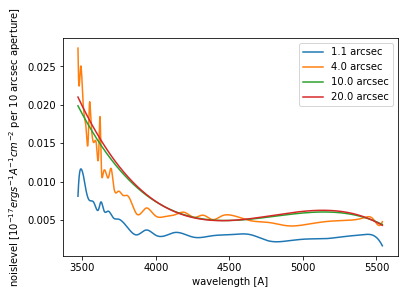

In [51]:
from scipy.interpolate import UnivariateSpline



smoothing = 0.003
for r in rr[:]:
    
    #plt.plot(ww, ss[r], label="{:.1f} arcsec".format(r*2))

    ii = ww > 0.
    spl = UnivariateSpline(ww[ii], ss[r][ii], k=3, s=smoothing)
    kappa = 3.5
    sigma = np.nanstd(ss[r]-spl(ww))

    jj = (np.abs(ss[r]-spl(ww)) < kappa*sigma) 
    spl = UnivariateSpline(ww[ii*jj],  ss[r][ii*jj], k=3, s=smoothing)

    plt.plot(ww, spl(ww), label="{:.1f} arcsec".format(r*2))
    
plt.legend()
plt.xlabel('wavelength [A]')
plt.ylabel('noislevel [$10^{-17} erg s^{-1} A^{-1} cm^{-2}$ per 10 arcsec aperture]')

In [23]:
ss

{0.5641895835477563: array([0.00936714, 0.011327  , 0.0125189 , ..., 0.00225465, 0.00298276,
        0.00260198]),
 2.0: array([0.02772602, 0.02087837, 0.02600466, ..., 0.00443476, 0.0046408 ,
        0.00329265]),
 5.0: array([0.02944175, 0.02427608, 0.02448876, ..., 0.00508704, 0.00558082,
        0.00445073]),
 10.0: array([0.02750936, 0.0257342 , 0.02642674, ..., 0.0051821 , 0.00486059,
        0.00465591])}

In [361]:
### Understaning noise scaling

In [383]:
scale = 1.

In [384]:
im = np.random.normal(size=[500,500], scale=scale)

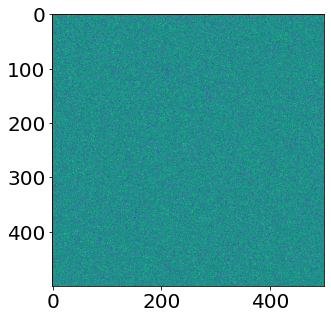

In [385]:
plt.imshow(im)

In [386]:
print("{:.2e}".format(np.std(im[:50,:50]/50.)))

1.99e-02


In [387]:
ss = []
for i in range(1000):
    s = np.mean( np.random.normal(size=[50,50], scale=scale) )
    ss.append(s)
print("{:.2e}".format(np.std(ss)))

2.02e-02


In [388]:
np.mean( np.ones([50,50]) * 2.03e-02 )

0.020299999999999995

In [394]:
im[:50,:50] = im[:50,:50] + 2.03e-02 

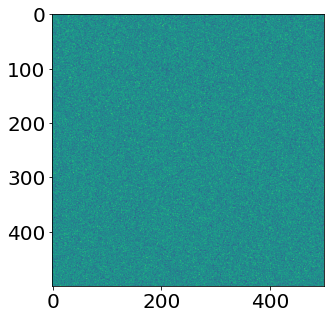

In [395]:
plt.imshow(im)

In [396]:
bim = np.zeros([10,10])
for i in range(10):
    for j in range(10):
       bim[i,j] = np.mean( im[50*i:50*(i+1),50*j:50*(j+1)] ) 

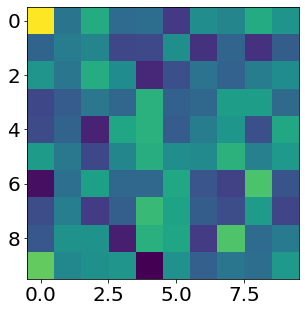

In [397]:
plt.imshow(bim)

In [398]:
np.std(bim)

0.018672173477383223

In [399]:
bim[0,0]

0.06201561794120735